In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
os.getcwd()
if os.getcwd() != '/content/drive/MyDrive/Projects/RBCs_Borealis_AIs_Shelter_Occupancy_Forecast':
  os.chdir('drive/MyDrive/Projects/RBCs_Borealis_AIs_Shelter_Occupancy_Forecast')
os.getcwd()

import pandas as pd
import torch
import plotting as pl
import dataload as dl
import math
from copy import deepcopy as dc

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets

DATASET_DIR = 'Datasets'

In [2]:
data_21 = r'{}/daily-shelter-overnight-service-occupancy-capacity-2021.csv'.format(DATASET_DIR)
data_22 = r'{}/daily-shelter-overnight-service-occupancy-capacity-2022.csv'.format(DATASET_DIR)
data_23 = r'{}/daily-shelter-overnight-service-occupancy-capacity-2023.csv'.format(DATASET_DIR)

links = [data_23, data_22, data_21]

#Weather Data
data_w_21 = r'{}/en_climate_daily_ON_6158355_2021_P1D.csv'.format(DATASET_DIR)
data_w_22 = r'{}/en_climate_daily_ON_6158355_2022_P1D.csv'.format(DATASET_DIR)
data_w_23 = r'{}/en_climate_daily_ON_6158355_2023_P1D.csv'.format(DATASET_DIR)

links_weather = [data_w_23, data_w_22, data_w_21]

#Housing
data_housing = r'{}/Housing.csv'.format(DATASET_DIR)

#Crisis helpline
data_crisis = r'{}/Persons_in_Crisis_Calls_for_Service_Attended_Open_Data.csv'.format(DATASET_DIR)

print(links_weather)

['Datasets/en_climate_daily_ON_6158355_2023_P1D.csv', 'Datasets/en_climate_daily_ON_6158355_2022_P1D.csv', 'Datasets/en_climate_daily_ON_6158355_2021_P1D.csv']


In [3]:
#Load Data takes in all the datasets and create a general dataframe to be adapted again for training different types of Model
dataframe, iso_data = dl.loadData(links, links_weather, data_housing, data_crisis)
#Function output explanation:
#	--DataFrame-- is the general combined data of all datasets, unaltered.
#	--iso_data-- is the dataframe but broken up into a hashmap where the key is the shelter id and the value is the data for that specific shelter

print(dataframe)

df = dl.merge_Shelters_Data(dataframe)

print(df)

Number of rows in the dataFrame: Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv 48345
Number of rows in the dataFrame: Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv 49478
Number of rows in the dataFrame: Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv 50944
Number of rows in the dataFrame: Datasets/en_climate_daily_ON_6158355_2023_P1D.csv 365
Number of rows in the dataFrame: Datasets/en_climate_daily_ON_6158355_2022_P1D.csv 365
Number of rows in the dataFrame: Datasets/en_climate_daily_ON_6158355_2021_P1D.csv 365
Number of rows in the dataFrame: Datasets/Housing.csv 62160
Number of rows in the dataFrame: Datasets/Persons_in_Crisis_Calls_for_Service_Attended_Open_Data.csv 291991
       OCCUPANCY_DATE                     ORGANIZATION_NAME  \
0          2021-01-01              COSTI Immigrant Services   
1          2021-01-01  St. Felix Social Ministries Outreach   
2          2021-01-01  St. Felix Social Ministries Outreac

In [104]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

class RetriveFeatureImportance():
  def __init__(self):
    self.rf = RandomForestRegressor()

  def get_sorted_feature_importance_list(self, X, y, plot_title='Feature Importances'):

    # Train Random Forest regressor
    self.rf.fit(X, y)

    # Get feature importances
    importances = self.rf.feature_importances_

    # Sort feature importances in descending order
    sorted_indices = importances.argsort()[::-1]
    sorted_importances = importances[sorted_indices]

    sorted_column_headers = self.get_sorted_importances_column_headers(X, sorted_indices)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(X.shape[1]), sorted_importances, tick_label=sorted_column_headers)
    plt.xticks(rotation=90)
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Importance')
    plt.title(plot_title)
    plt.show()

    return sorted_indices, sorted_importances, sorted_column_headers

  def get_sorted_importances_column_headers(self, X, sorted_indices):
    column_headers = X.columns.tolist()  # Example column headers
    sorted_column_headers = [column_headers[i] for i in sorted_indices]
    return sorted_column_headers

  def plot_header_against_date(self, date_array, column_data_array, y_axis):
    # Plot the line graph
    plt.ticklabel_format(axis='x', style='plain')
    plt.ticklabel_format(axis='y', style='plain')

    plt.plot(date_array, column_data_array)
    plt.xticks(rotation=90)

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel(y_axis)
    plt.title('Date vs {}'.format(y_axis))

    # Show the plot
    plt.show()

  def plot_each_column(self, date_array, sorted_column_headers, sorted_importances):
    for i in range(len(sorted_column_headers)):
      print("Feature importance for {}: {}".format(sorted_column_headers[i], sorted_importances[i]))
      column_data_array = df[sorted_column_headers[i]].tolist()
      self.plot_header_against_date(date_array, column_data_array, sorted_column_headers[i])


In [105]:
X = dc(df).drop(columns=['OCCUPIED_PERCENTAGE'])
X['OCCUPANCY_DATE'] = X['OCCUPANCY_DATE'].dt.strftime('%Y%m%d').astype(int)

y = df['OCCUPIED_PERCENTAGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


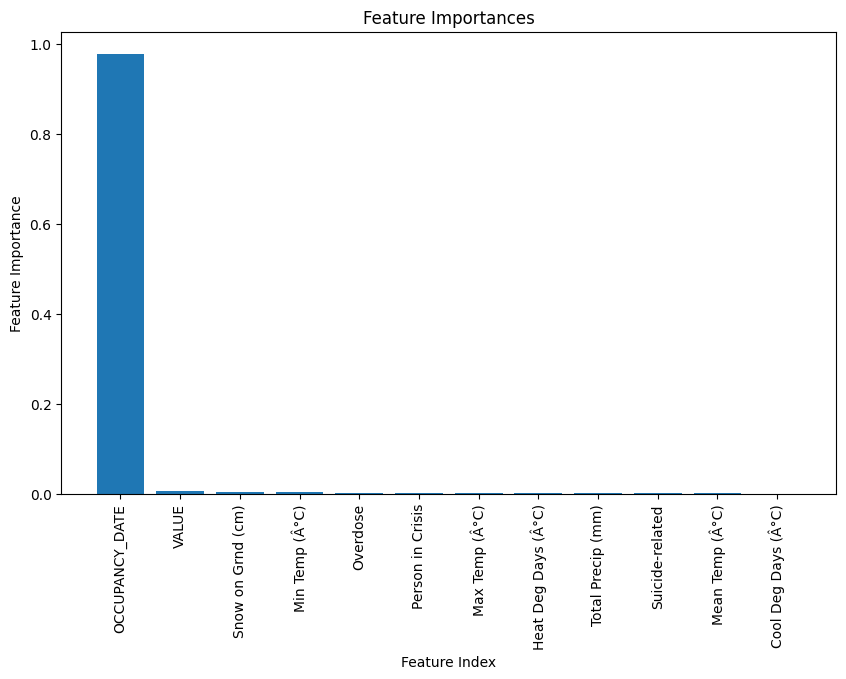

Sorted feature importance : ['OCCUPANCY_DATE', 'VALUE', 'Snow on Grnd (cm)', 'Min Temp (Â°C)', 'Overdose', 'Person in Crisis', 'Max Temp (Â°C)', 'Heat Deg Days (Â°C)', 'Total Precip (mm)', 'Suicide-related', 'Mean Temp (Â°C)', 'Cool Deg Days (Â°C)']


In [108]:
feature_importance = RetriveFeatureImportance()

sorted_importance_indices, sorted_importances, sorted_column_headers = feature_importance.get_sorted_feature_importance_list(X, y)
print("Sorted feature importance : {}".format(sorted_column_headers))


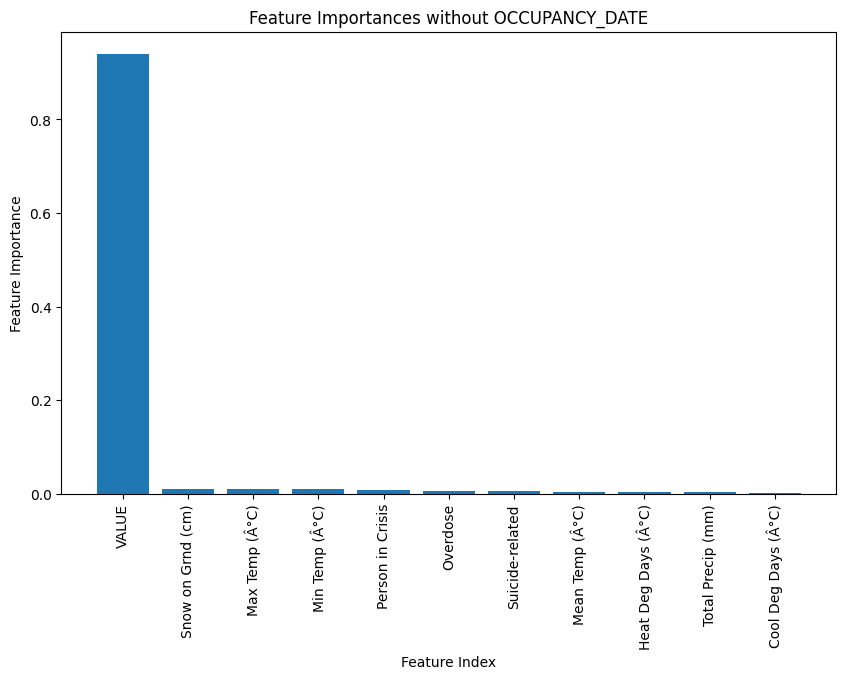

Sorted feature importance : ['VALUE', 'Snow on Grnd (cm)', 'Max Temp (Â°C)', 'Min Temp (Â°C)', 'Person in Crisis', 'Overdose', 'Suicide-related', 'Mean Temp (Â°C)', 'Heat Deg Days (Â°C)', 'Total Precip (mm)', 'Cool Deg Days (Â°C)']
Feature importance for VALUE: 0.940857165639019


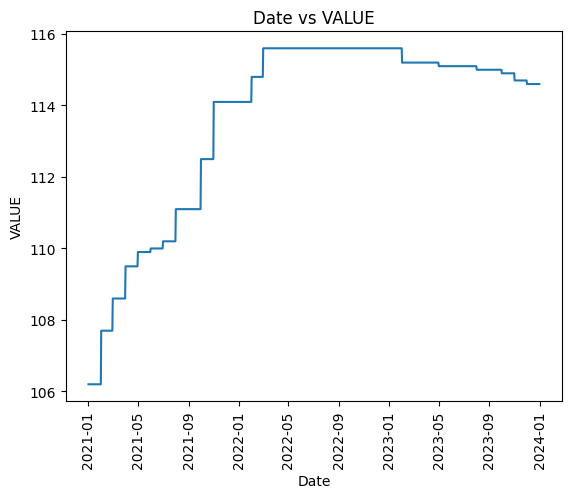

Feature importance for Snow on Grnd (cm): 0.010362546037946339


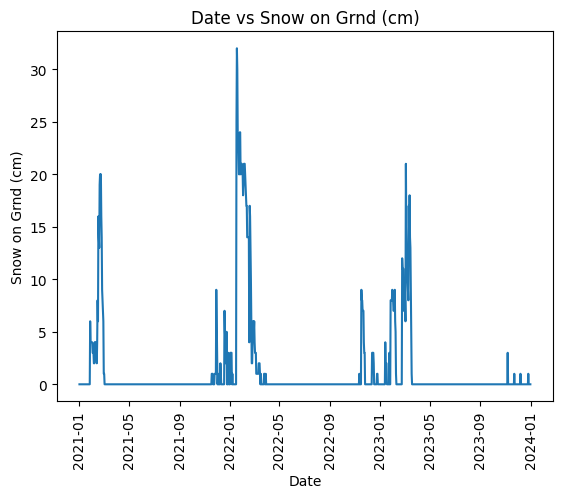

Feature importance for Max Temp (Â°C): 0.009495841347879815


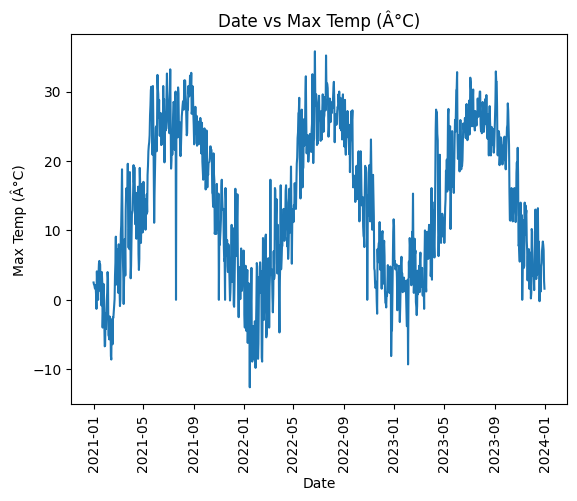

Feature importance for Min Temp (Â°C): 0.009326866604229397


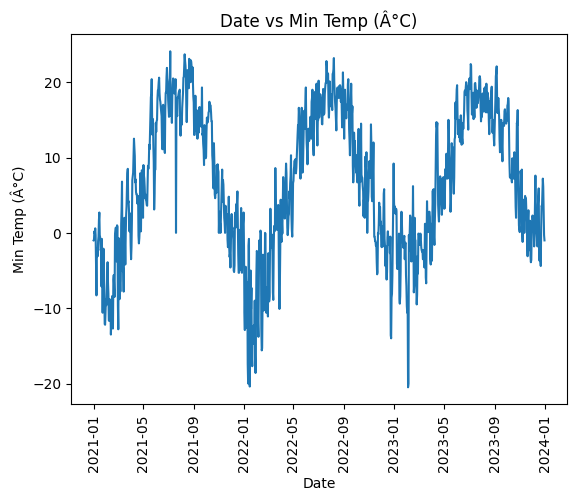

Feature importance for Person in Crisis: 0.007938984691927917


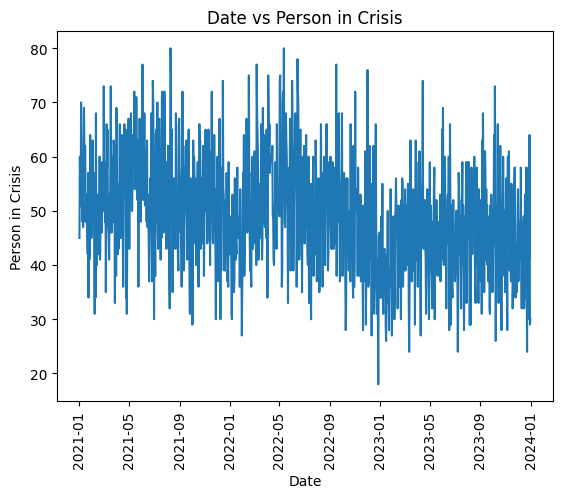

Feature importance for Overdose: 0.005807407358313063


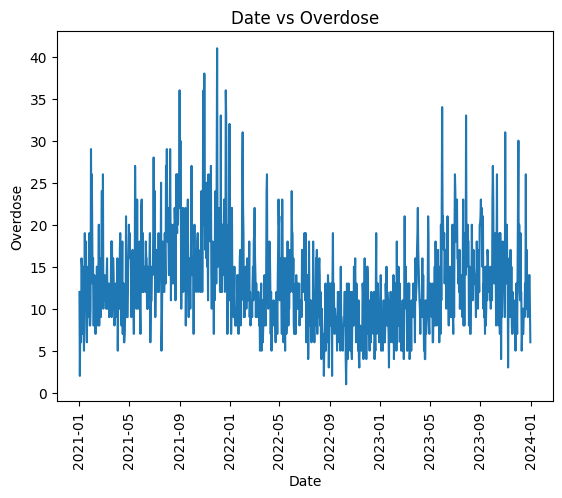

Feature importance for Suicide-related: 0.004629873626373093


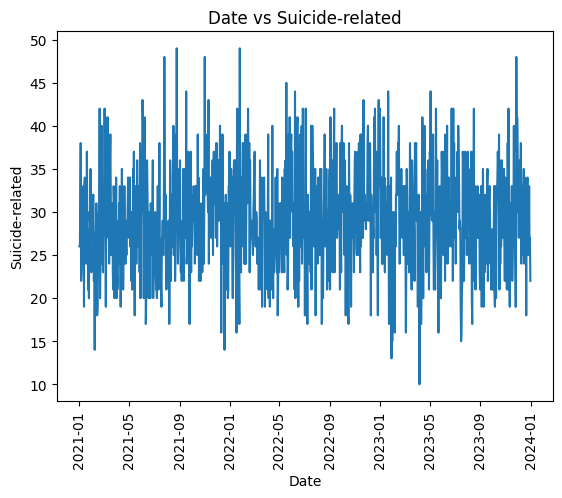

Feature importance for Mean Temp (Â°C): 0.004025440077913687


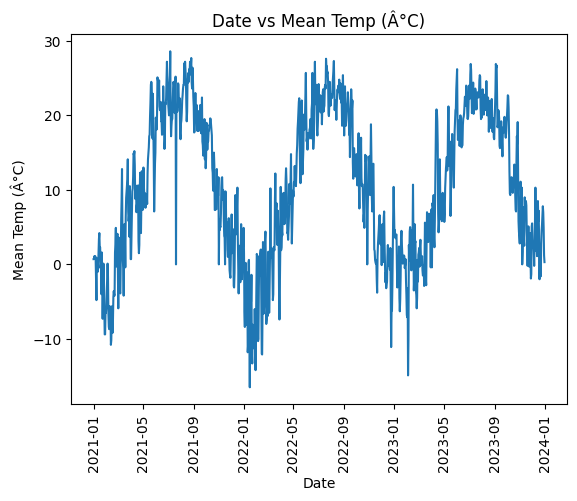

Feature importance for Heat Deg Days (Â°C): 0.0038225768024243803


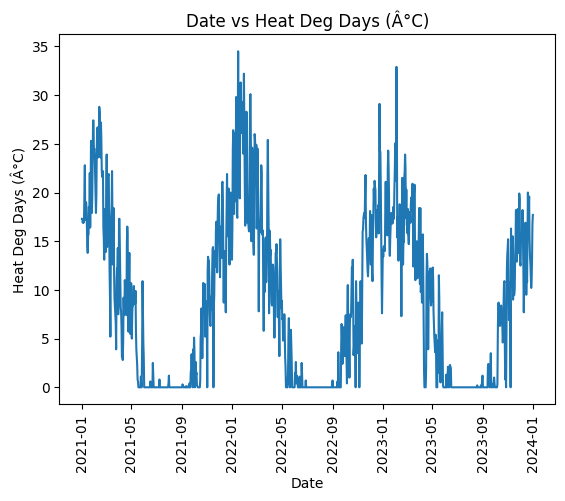

Feature importance for Total Precip (mm): 0.0029363894029207946


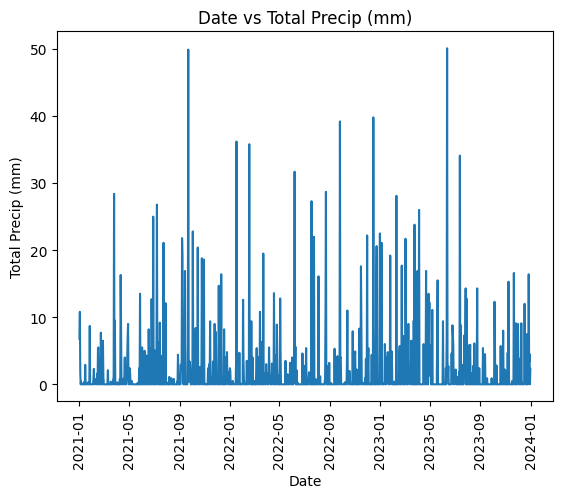

Feature importance for Cool Deg Days (Â°C): 0.0007969084110525732


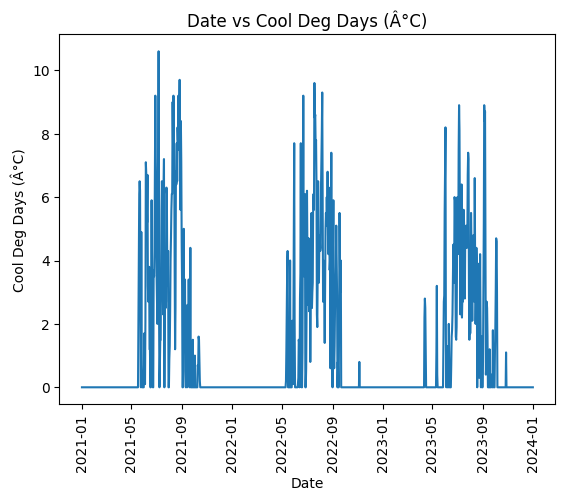

In [109]:
dropped_columns = ['OCCUPANCY_DATE']
X_w_dropped_occ_date = X.drop(columns=dropped_columns)
plot_title = 'Feature Importances without {}'.format(', '.join(dropped_columns))
sorted_importance_indices_w_dropped_occ_date, sorted_importances_w_dropped_occ_date, sorted_column_headers_w_dropped_occ_date = feature_importance.get_sorted_feature_importance_list(X_w_dropped_occ_date, y,  plot_title=plot_title)
print("Sorted feature importance : {}".format(sorted_column_headers_w_dropped_occ_date))

date_array = df['OCCUPANCY_DATE'].tolist()
feature_importance.plot_each_column(date_array, sorted_column_headers_w_dropped_occ_date, sorted_importances_w_dropped_occ_date)